In [1]:
%pip install ultralytics
%pip install ttach

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from yolov8_cam.eigen_cam import EigenCAM
from yolov8_cam.utils.image import show_cam_on_image

/home/cwlroda/.virtualenvs/script-library/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = YOLO('models/yolov8n.pt')

In [4]:
img = cv2.imread('images/puppies.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [5]:
target_layers = [model.model.model[-4]]


0: 640x640 7 dogs, 367.3ms
Speed: 17.0ms preprocess, 367.3ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


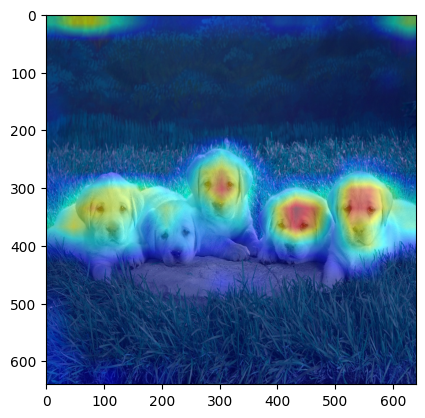

In [6]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(
    rgb_img,
    eigen_smooth=True,
)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()